In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import ndcg_score
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import lightgbm as lgb
import numpy as np

In [91]:
def read_data() -> pd.DataFrame : 
    trc=pd.read_excel(r'C:\Users\Family\Desktop\WIDS-Com\Train\TRAIN_CATEGORICAL_new.xlsx')
    trq=pd.read_excel(r'C:\Users\Family\Desktop\WIDS-Com\Train\TRAIN_QUANTITATIVE_new.xlsx')
    trf=pd.read_csv(r'C:\Users\Family\Desktop\WIDS-Com\Train\TRAIN_FUNCTIONAL_new.csv')
    trs=pd.read_excel(r'C:\Users\Family\Desktop\WIDS-Com\Train\up_SOLUTIONS (3).xlsx')  
    trs=pd.read_excel(r'C:\Users\Family\Desktop\WIDS-Com\Train\TRAINING_SOLUTIONS.xlsx')  
    tsc=pd.read_excel(r'C:\Users\Family\Desktop\WIDS-Com\Test\TEST_CATEGORICAL.xlsx')
    tsq=pd.read_excel(r'C:\Users\Family\Desktop\WIDS-Com\Train\TEST_QUANTITATIVE_METADATA.xlsx')    
    tsf=pd.read_csv(r'C:\Users\Family\Desktop\WIDS-Com\Test\TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')    
    sub=pd.read_excel(r'C:\Users\Family\Desktop\WIDS-Com\Submission\SAMPLE_SUBMISSION.xlsx')    
    dic=pd.read_excel(r'C:\Users\Family\Desktop\WIDS-Com\Submission\Data Dictionary.xlsx')
    return trc, trq, trf, trs, tsc, tsq, tsf, sub, dic

trc, trq, trf, trs, tsc, tsq, tsf, sub, dic = read_data()

In [92]:
cq = pd.merge(trc, trq, on='participant_id', how='left')
feat = pd.merge(cq, trf, on='participant_id', how='left')  
qc = pd.merge(tsc, tsq, on='participant_id', how='left')
train = pd.merge(feat, trs, on='participant_id', how='left') 
test = pd.merge(qc, tsf, on='participant_id', how='left')  

In [93]:
target = train[['ADHD_Outcome', 'Sex_F']].values
id = train['participant_id'].values
train = train.drop(columns=['participant_id','ADHD_Outcome', 'Sex_F'])
id_test = test['participant_id'].values
test = test.drop(columns=['participant_id'])



In [94]:
missing_data = ((test.isnull().sum()/ (len(test)) * 100))
missing_data = pd.DataFrame(missing_data, columns=["missing value"]) 
missing_data.index.name = "columns"  
missing_data = missing_data.sort_values(by="missing value", ascending=False)  
missing_data.head(30)

,missing value
columns,
Barratt_Barratt_P2_Occ,13.815789
Barratt_Barratt_P2_Edu,11.842105
SDQ_SDQ_Generating_Impact,9.868421
SDQ_SDQ_Prosocial,9.868421
SDQ_SDQ_Peer_Problems,9.868421
SDQ_SDQ_Internalizing,9.868421
SDQ_SDQ_Hyperactivity,9.868421
SDQ_SDQ_Externalizing,9.868421
SDQ_SDQ_Emotional_Problems,9.868421


In [95]:
train_clean = train.copy()
test_clean = test.copy()

missing_train = train_clean.isnull().sum()
print("Missing values in training data:")
print(missing_train[missing_train > 0])
  

Missing values in training data:
PreInt_Demos_Fam_Child_Ethnicity     43
PreInt_Demos_Fam_Child_Race          54
MRI_Track_Scan_Location               3
Barratt_Barratt_P1_Edu               15
Barratt_Barratt_P1_Occ               31
Barratt_Barratt_P2_Edu              198
Barratt_Barratt_P2_Occ              222
EHQ_EHQ_Total                        13
ColorVision_CV_Score                 23
APQ_P_APQ_P_CP                       12
APQ_P_APQ_P_ID                       12
APQ_P_APQ_P_INV                      12
APQ_P_APQ_P_OPD                      12
APQ_P_APQ_P_PM                       12
APQ_P_APQ_P_PP                       12
SDQ_SDQ_Conduct_Problems              9
SDQ_SDQ_Difficulties_Total            9
SDQ_SDQ_Emotional_Problems            9
SDQ_SDQ_Externalizing                 9
SDQ_SDQ_Generating_Impact             9
SDQ_SDQ_Hyperactivity                 9
SDQ_SDQ_Internalizing                 9
SDQ_SDQ_Peer_Problems                 9
SDQ_SDQ_Prosocial                     9
MRI_Tra

In [96]:
missing_test = test_clean.isnull().sum()
print("Missing values in test data:")   
print(missing_test[missing_test > 0]) 

Missing values in test data:
columns
PreInt_Demos_Fam_Child_Ethnicity     3
PreInt_Demos_Fam_Child_Race          6
Barratt_Barratt_P1_Edu               1
Barratt_Barratt_P1_Occ               1
Barratt_Barratt_P2_Edu              36
Barratt_Barratt_P2_Occ              42
EHQ_EHQ_Total                        1
ColorVision_CV_Score                 9
APQ_P_APQ_P_CP                      15
APQ_P_APQ_P_ID                      15
APQ_P_APQ_P_INV                     15
APQ_P_APQ_P_OPD                     15
APQ_P_APQ_P_PM                      15
APQ_P_APQ_P_PP                      15
SDQ_SDQ_Conduct_Problems            30
SDQ_SDQ_Difficulties_Total          30
SDQ_SDQ_Emotional_Problems          30
SDQ_SDQ_Externalizing               30
SDQ_SDQ_Generating_Impact           30
SDQ_SDQ_Hyperactivity               30
SDQ_SDQ_Internalizing               30
SDQ_SDQ_Peer_Problems               30
SDQ_SDQ_Prosocial                   30
dtype: int64


## 6. Numerical Feature Scaling

In [97]:
# Identify numerical columns to scale (excluding IDs and dates and the target column)
numeric_cols = train_clean.select_dtypes(include=[np.number]).columns.tolist()  

# Check if all the numerical columns exist in the DataFrames
numerical_cols = [col for col in numeric_cols if col in train_clean.columns]

# Create a scaler
scaler = StandardScaler()

# Fit and transform the training data
train_clean[numerical_cols] = scaler.fit_transform(train_clean[numerical_cols])

# Transform the test data
train_clean[numerical_cols] = scaler.transform(train_clean[numerical_cols])

# Check the scaled columns
print("Numerical columns after scaling:")
train_clean[numerical_cols].describe().T

Numerical columns after scaling:


,count,mean,std,min,25%,50%,75%,max
Basic_Demos_Enroll_Year,1213.0,-1798.169204,0.891586,-1800.275691,-1798.687150,-1797.892879,-1797.098609,-1796.304338
Basic_Demos_Study_Site,1213.0,-1.775691,0.881670,-2.563918,-2.563918,-2.563918,-1.010515,-0.233814
PreInt_Demos_Fam_Child_Ethnicity,1170.0,-0.629112,1.443874,-1.537082,-1.537082,-1.537082,0.545908,4.711890
PreInt_Demos_Fam_Child_Race,1159.0,-0.679821,0.312303,-0.892040,-0.892040,-0.794591,-0.697142,0.179900
MRI_Track_Scan_Location,1210.0,-3.057528,1.333263,-5.356212,-3.580090,-3.580090,-1.803968,-0.027846
...,...,...,...,...,...,...,...,...
196throw_198thcolumn,1213.0,-1.902975,5.054807,-20.705637,-4.813986,-1.517074,1.806027,10.600268
196throw_199thcolumn,1213.0,-1.939173,5.233107,-27.216374,-5.445499,-1.451657,1.761896,10.594982
197throw_198thcolumn,1213.0,-2.827615,5.652874,-28.460641,-6.382445,-2.058342,1.323999,10.378264
197throw_199thcolumn,1213.0,-2.681653,5.631105,-27.510061,-6.117600,-2.057959,1.235867,10.689961


In [98]:
train_clean

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,EHQ_EHQ_Total,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,-1797.098609,-0.233814,0.545908,-0.892040,-1.803968,-4.841934,-1.455779,NaN,NaN,-1.180530,...,-2.746574,-0.023234,-5.598874,0.665862,-9.619108,-5.328363,-2.883134,-5.959088,-7.386692,-3.335317
1,-1798.687150,-2.563918,-1.537082,-0.014998,-3.580090,-4.841934,-1.616172,-4.029681,-2.101337,-1.183656,...,-5.366171,-4.349799,-6.847837,-8.708796,-3.710729,0.623338,-0.338858,-4.182816,-7.872840,-1.368722
2,-1798.687150,-2.563918,0.545908,-0.697142,-3.580090,-5.819210,-1.616172,NaN,NaN,-1.185921,...,-5.107897,-0.314955,1.022586,-4.730638,1.683232,-4.107029,1.234047,-10.656734,0.442293,-1.050874
3,-1797.892879,-2.563918,4.711890,-0.112447,-3.580090,-5.086253,-1.580529,-4.224155,-2.334441,-1.183224,...,-4.091936,1.299390,-3.677126,-5.765435,-5.381497,-3.895277,-0.714553,-2.470268,-6.332016,-6.526942
4,-1797.892879,-2.563918,-1.537082,-0.794591,-3.580090,-5.574891,-1.616172,NaN,NaN,-1.220975,...,-5.797859,-4.290995,-2.283153,-0.357626,-5.553814,-2.936546,-3.424457,-4.685371,-12.165657,-8.886812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,-1797.098609,-0.233814,0.545908,-0.794591,-1.803968,-5.574891,NaN,-4.418630,-2.308540,-1.180530,...,2.872774,5.250655,3.758050,5.064996,-1.758153,3.470891,-3.526659,-3.289833,-11.784752,-9.713741
1209,-1797.892879,-2.563918,-1.537082,-0.892040,-1.803968,-4.841934,-1.473600,-4.029681,-2.127237,-1.202099,...,7.943054,7.073656,7.119032,4.746708,0.318783,-10.107873,1.379205,-15.016009,-4.965607,-3.401330
1210,-1797.892879,-1.010515,2.628899,-0.599693,-1.803968,-4.841934,-1.473600,-4.029681,-2.153138,-1.237154,...,1.585062,2.238520,2.136202,5.661878,-4.525426,-10.898705,0.841175,-15.752023,-11.270719,-15.643250
1211,-1797.098609,-0.233814,-1.537082,-0.794591,-1.803968,-5.086253,-1.491422,-4.224155,-2.101337,-1.180530,...,-1.067024,5.806222,0.217504,-1.858684,2.875963,-6.838827,-9.210151,-5.380364,-12.937224,2.456232


In [99]:
# Identify numerical columns to scale (excluding IDs and dates and the target column)
numeric_cols = test_clean.select_dtypes(include=[np.number]).columns.tolist()  

# Check if all the numerical columns exist in the DataFrames
numerical_cols = [col for col in numeric_cols if col in test_clean.columns]

# Create a scaler
scaler = StandardScaler()

# Fit and transform the training data
test_clean[numerical_cols] = scaler.fit_transform(test_clean[numerical_cols])

# Transform the test data
test_clean[numerical_cols] = scaler.transform(test_clean[numerical_cols])

# Check the scaled columns
print("Numerical columns after scaling:")
test_clean[numerical_cols].describe().T

Numerical columns after scaling:


,count,mean,std,min,25%,50%,75%,max
columns,,,,,,,,
Basic_Demos_Enroll_Year,304.0,-4094.318622,2.028026,-4107.425790,-4095.127706,-4095.127706,-4095.127706,-4091.028345
Basic_Demos_Study_Site,304.0,-40.565780,10.133167,-41.575747,-41.575747,-41.575747,-41.575747,60.767553
PreInt_Demos_Fam_Child_Ethnicity,301.0,-0.534853,1.507092,-1.339585,-1.339585,-1.339585,0.924195,5.451754
PreInt_Demos_Fam_Child_Race,298.0,-0.658813,0.295724,-0.853313,-0.853313,-0.853313,-0.591835,0.105440
MRI_Track_Scan_Location,304.0,-7.571081,2.084452,-10.334718,-10.334718,-6.004071,-6.004071,-6.004071
...,...,...,...,...,...,...,...,...
196throw_198thcolumn,304.0,-1.741796,4.931384,-15.191270,-4.613266,-1.250395,2.014171,8.598321
196throw_199thcolumn,304.0,-1.948351,5.130743,-17.540329,-4.977225,-1.322227,1.946891,8.147097
197throw_198thcolumn,304.0,-2.956806,5.878249,-21.704659,-6.469244,-1.717476,1.296646,9.306881


In [11]:
# Convert target to a pandas DataFrame
target_df = pd.DataFrame(target, columns=['ADHD_Outcome', 'Sex_F'])

# Access columns by their labels
y_sex = target_df['Sex_F']
y_adhd = target_df['ADHD_Outcome']


# stratified cross-validation

# feature importance in adhd

In [82]:
X = train_clean
X = pd.get_dummies(X, drop_first=True)

# Initialize the label encoder
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y_adhd)
model = lgb.LGBMClassifier()
model.fit(X, y)
importances = model.feature_importances_
feature_names = X.columns
feature_importances = zip(feature_names, importances)

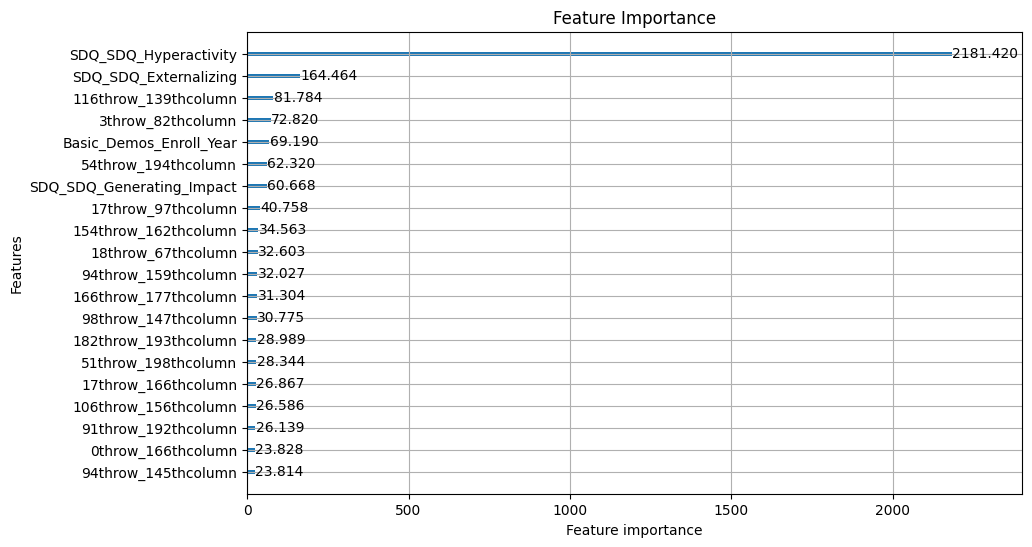

In [83]:
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance")
plt.show()

In [84]:
# Get the feature importance values and feature names
feature_importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Set a threshold for importance (e.g., greater than 0)
important_features = importance_df[importance_df['Importance'] > 0]['Feature']

# Filter the training data to keep only important features
train_adhd_filtered = train_clean[important_features]
test_adhd_filtered = test_clean[important_features]
# Display the new DataFrame
print("Filtered training data for ADHD:")
print(train_adhd_filtered.head())

Filtered training data for ADHD:
   Basic_Demos_Enroll_Year  EHQ_EHQ_Total  APQ_P_APQ_P_OPD  \
0             -1797.098609      -1.180530        -5.747097   
1             -1798.687150      -1.183656        -4.756648   
2             -1798.687150      -1.185921        -5.386934   
3             -1797.892879      -1.183224        -5.657056   
4             -1797.892879      -1.220975        -5.026770   

   SDQ_SDQ_Difficulties_Total  SDQ_SDQ_Externalizing  \
0                   -1.761992              -1.645469   
1                   -1.691305              -1.528140   
2                   -1.597055              -1.704134   
3                   -2.044742              -2.114787   
4                   -1.620617              -1.410810   

   SDQ_SDQ_Generating_Impact  SDQ_SDQ_Hyperactivity  0throw_1thcolumn  \
0                  -1.348295              -1.661489          2.321263   
1                  -1.348295              -1.661489         -3.132338   
2                  -0.713677          

# feature importance in sex

In [15]:
X = train_clean
X = pd.get_dummies(X, drop_first=True)

# Initialize the label encoder
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y_sex)
model_sex = lgb.LGBMClassifier()
model_sex.fit(X, y)  # Fit the model before accessing feature_importances_
importances_sex = model_sex.feature_importances_
feature_names = X.columns
feature_importances = zip(feature_names, importances_sex)

[LightGBM] [Info] Number of positive: 416, number of negative: 797
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.554622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5075211
[LightGBM] [Info] Number of data points in the train set: 1213, number of used features: 19927
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.342951 -> initscore=-0.650169
[LightGBM] [Info] Start training from score -0.650169


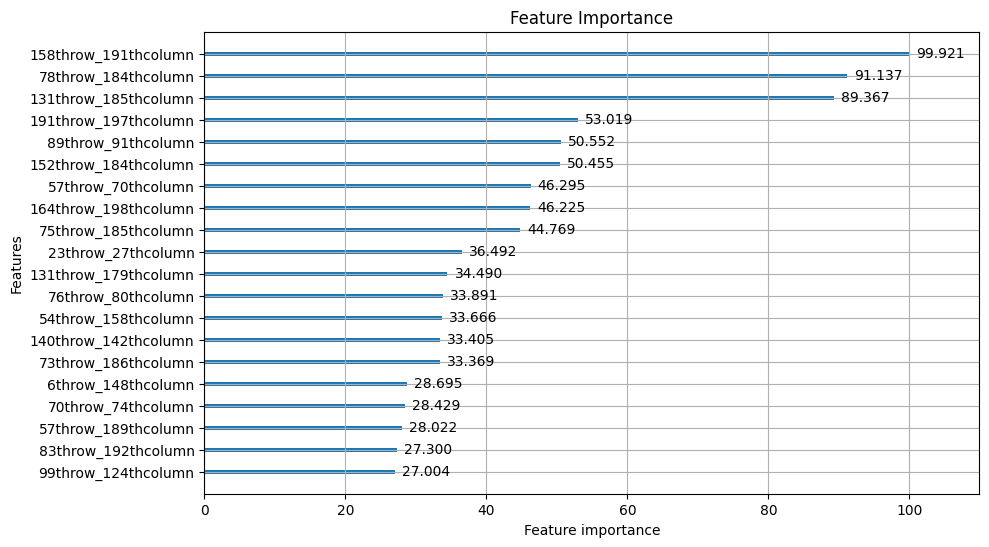

In [16]:
lgb.plot_importance(model_sex, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Feature Importance")
plt.show()

In [49]:
# Get the feature importance values and feature names for the Sex model
feature_importances_sex = model_sex.feature_importances_
feature_names_sex = X.columns

# Create a DataFrame for feature importances
importance_df_sex = pd.DataFrame({'Feature': feature_names_sex, 'Importance': feature_importances_sex})

# Set a threshold for importance (e.g., greater than 0)
important_features_sex = importance_df_sex[importance_df_sex['Importance'] > 0]['Feature']

# Filter the training data to keep only important features for the Sex model
train_sex_filtered = train_clean[important_features_sex]
test_sex_filtered = test_clean[important_features]

# Display the new DataFrame
print("Filtered training data for Sex:")
print(train_sex_filtered.head())

Filtered training data for Sex:
   PreInt_Demos_Fam_Child_Race  Barratt_Barratt_P2_Occ  APQ_P_APQ_P_INV  \
0                    -0.892040                     NaN        -7.986277   
1                    -0.014998               -2.101337        -8.365645   
2                    -0.697142                     NaN        -8.281341   
3                    -0.112447               -2.334441        -8.070581   
4                    -0.794591                     NaN        -8.365645   

   SDQ_SDQ_Conduct_Problems  SDQ_SDQ_Emotional_Problems  \
0                 -0.799739                   -0.716298   
1                 -0.310634                   -0.716298   
2                 -0.799739                   -0.076555   
3                 -1.533398                   -1.569288   
4                 -0.066081                   -0.076555   

   SDQ_SDQ_Hyperactivity  SDQ_SDQ_Prosocial  0throw_4thcolumn  \
0              -1.661489          -3.409588          1.718203   
1              -1.661489        

# training

# ADHD without bagging

In [ ]:
# Initialize Stratified K-Fold
FOLDS = 5
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Prepare data
X = train_adhd_filtered
y = y_adhd

# Initialize storage for out-of-fold predictions
oof_predictions = np.zeros(len(X))

# Loop through each fold
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Training fold {fold + 1}/{FOLDS}...")
    
    # Split data into training and validation sets
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # Define LightGBM model
    model_sep_adhd = lgb.LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )
    
    # Train the model
    model_sep_adhd.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='binary_logloss',
    )
    
    # Make predictions
    valid_preds = model_sep_adhd.predict(X_valid)
    oof_predictions[valid_idx] = valid_preds
    
    # Calculate F1 score for the current fold
    fold_f1 = f1_score(y_valid, valid_preds, average='macro')
    print(f"Fold {fold + 1} F1 Score: {fold_f1:.4f}")

# Calculate overall F1 score
overall_f1 = f1_score(y, oof_predictions, average='macro')
print(f"\nOverall F1 Score: {overall_f1:.4f}")

Training fold 1/5...
Fold 1 F1 Score: 0.7424
Training fold 2/5...
Fold 2 F1 Score: 0.7431
Training fold 3/5...
Fold 3 F1 Score: 0.7469
Training fold 4/5...
Fold 4 F1 Score: 0.7607
Training fold 5/5...
Fold 5 F1 Score: 0.6594

Overall F1 Score: 0.7307


72 when depth =-1 and n_estimators = 100
72 when depth =4 and n_estimators = 300


# SEX wigh bagging + downsampling

In [ ]:
#
train_sex_filtered = train_sex_filtered.fillna(train_sex_filtered.mean())

# Fill categorical columns with mode
categorical_cols = train_sex_filtered.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    train_sex_filtered[col] = train_sex_filtered[col].fillna(train_sex_filtered[col].mode()[0])


In [19]:
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier

# Initialize storage
oof_sex = np.zeros(len(train_clean))
models_sep_sex = {}  # Initialize models_sep_sex as an empty dictionary
bag_f1_sex = []

BAGS = 5
FOLDS = 5

# Prepare data
train_sex_filtered = train_sex_filtered.reset_index(drop=True)
y_sex = y_sex.reset_index(drop=True)

for bag in range(BAGS):
    print('#'*25)
    print(f'### Bag {bag+1}')
    print('#'*25)
    
    models_sep_sex[bag] = []
    bag_pred_sex = np.zeros(len(train_clean))
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=bag)
    fold_f1_sex = []
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X=train_sex_filtered, y=y_sex)):
        print(f'=> Fold {fold+1}, ', end='')

        # Dynamic class balancing
        y_train_sex = y_sex.iloc[train_idx]
        class_counts = y_train_sex.value_counts()
        majority_class = class_counts.idxmax()
        minority_class = 1 - majority_class
        
        majority_samples = y_train_sex[y_train_sex == majority_class]
        minority_samples = y_train_sex[y_train_sex == minority_class]
        
        n_samples = len(minority_samples)
        if len(majority_samples) < n_samples:
            n_samples = len(majority_samples)
        
        downsampled_majority = majority_samples.sample(
            n=n_samples, 
            replace=len(majority_samples) < len(minority_samples),
            random_state=bag*BAGS+fold
        )
        
        sex_train_idx = minority_samples.index.union(downsampled_majority.index)
        X_train_sex = train_sex_filtered.iloc[sex_train_idx]
        y_train_sex_balanced = y_sex.iloc[sex_train_idx]
        X_valid_sex = train_sex_filtered.iloc[valid_idx]
        y_valid_sex = y_sex.iloc[valid_idx]

        # Model parameters
        model_params = {
            'n_estimators': 300,
            'learning_rate': 0.05,
            'num_leaves': 15,
            'max_depth': 6,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'min_child_samples': 20,
            'colsample_bytree': 0.3,
            'subsample': 0.8,
            'early_stopping_round': 20,
            'metric': 'binary_logloss',
            'verbose': -1
        }

        model_sep_sex = LGBMClassifier(**model_params, class_weight='balanced')
        model_sep_sex.fit(X_train_sex, y_train_sex_balanced,
                          eval_set=[(X_valid_sex, y_valid_sex)])

        sex_pred = model_sep_sex.predict(X_valid_sex)
        fold_f1_sex.append(f1_score(y_valid_sex, sex_pred, average='macro'))
        
        bag_pred_sex[valid_idx] = model_sep_sex.predict_proba(X_valid_sex)[:, 1]
        models_sep_sex[bag].append(model_sep_sex)

    bag_avg_f1_sex = np.mean(fold_f1_sex)
    bag_f1_sex.append(bag_avg_f1_sex)
    print(f"\nBag {bag+1} Avg F1 - Sex: {bag_avg_f1_sex:.4f}")
    oof_sex += bag_pred_sex / BAGS

# Final evaluation
final_f1_sex = f1_score(y_sex, (oof_sex > 0.5).astype(int), average='macro')
print('\n' + '#'*50)
print(f"Final Ensemble F1 - Sex: {final_f1_sex:.4f}")
print(f"Mean Bag F1 - Sex: {np.mean(bag_f1_sex):.4f} ± {np.std(bag_f1_sex):.4f}")


#########################
### Bag 1
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 1 Avg F1 - Sex: 0.7244
#########################
### Bag 2
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 2 Avg F1 - Sex: 0.6776
#########################
### Bag 3
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 3 Avg F1 - Sex: 0.6861
#########################
### Bag 4
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 4 Avg F1 - Sex: 0.6931
#########################
### Bag 5
#########################
=> Fold 1, => Fold 2, => Fold 3, => Fold 4, => Fold 5, 
Bag 5 Avg F1 - Sex: 0.7057

##################################################
Final Ensemble F1 - Sex: 0.7416
Mean Bag F1 - Sex: 0.6974 ± 0.0164


# ADHD using Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer


# Define the model
model_log = LogisticRegression(random_state=42, class_weight={0: 1, 1: 10})

# Define the number of splits
n_splits = 5

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store scores
scores = []
roc_auc_scores = []
acc = []

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(train_clean_imputed, y_adhd)):
    # Split the data into training and validation sets
    train_val = train_clean_imputed.iloc[train_idx]
    test_val = train_clean_imputed.iloc[val_idx]
    y_train_val = y_adhd.iloc[train_idx]
    y_test_val = y_adhd.iloc[val_idx]
    
    # Fit the model
    model_log.fit(train_val, y_train_val)
    
    # Make predictions
    predictions = model_log.predict(test_val)
    
    # Print the proportion of positive predictions
    print(predictions.sum() / len(predictions))
    
    # Calculate and store metrics
    scores.append(f1_score(y_test_val, predictions))
    roc_auc_scores.append(roc_auc_score(y_test_val, predictions))
    acc.append(accuracy_score(y_test_val, predictions))

# Print the results
print("F1 Scores:", scores)
print("ROC AUC Scores:", roc_auc_scores)
print("Accuracy Scores:", acc)
print("Average F1 Score:", sum(scores) / len(scores))
print("Average ROC AUC Score:", sum(roc_auc_scores) / len(roc_auc_scores))
print("Average Accuracy:", sum(acc) / len(acc))

0.7366255144032922
0.7736625514403292
0.757201646090535
0.8181818181818182
0.7933884297520661
F1 Scores: [0.7456647398843931, 0.7344632768361582, 0.7428571428571429, 0.7527472527472527, 0.7430167597765364]
ROC AUC Scores: [0.557280176489127, 0.5149428884368643, 0.5409169144108903, 0.5113348129359543, 0.5124445149017121]
Accuracy Scores: [0.6378600823045267, 0.6131687242798354, 0.6296296296296297, 0.628099173553719, 0.6198347107438017]
Average F1 Score: 0.7437498344202966
Average ROC AUC Score: 0.5273838614349096
Average Accuracy: 0.6257184641023026


In [103]:
# Predict the Sex target using the trained models
sex_pred = np.zeros(len(test_clean))

for bag in range(BAGS):
    for fold in range(FOLDS):
        # Get the trained model for this bag and fold
        model_sex = models_sep_sex[bag][fold]
        
        # Ensure test_clean contains only the features used during training
        test_features_sex = train_sex_filtered.columns  # Use the same columns as in training for Sex
        test_clean_sex = test_clean[test_features_sex]

        # Make predictions for the test set
        sex_pred += model_sex.predict_proba(test_clean_sex)[:, 1] / (BAGS * FOLDS)

# Convert probabilities to binary predictions
sex_pred_binary = (sex_pred > 0.5).astype(int)



In [ ]:
# Ensure test_clean is preprocessed similarly to train_clean
test_clean_preprocessed = test_clean.fillna(test_clean.mean())

# Predict ADHD outcomes using the pipeline
adhd_pred = model_sep_adhd.predict(test_clean_preprocessed)
adhd_pred_binary = (adhd_pred > 0.5).astype(int)

In [ ]:
# Ensure all arrays have the same length
if len(id_test) == len(sex_pred_binary):
    # Create a DataFrame for submission
    submission = pd.DataFrame({
        'participant_id': id_test,
         'ADHD_Outcome' : adhd_pred_binary ,
        'Sex_F': sex_pred_binary  
    })

    # Save the submission file
    submission.to_csv('submission_Sex_0.7416_adhd_0.76417.csv', index=False)
    print("Submission file for Sex created successfully!")

Submission file for Sex created successfully!


trating to calculate the the score like the leaderbord 

In [ ]:
# the main code 

"""
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.feature_selection import VarianceThreshold

# Initialize storage
oof_sex = np.zeros(len(train_clean))
oof_adhd = np.zeros(len(train_clean))
models_sex = {}
models_adhd = {}

# Track F1 scores per bag
bag_f1_sex = []
bag_f1_adhd = []

BAGS = 5
FOLDS = 5

# Create copy of training data
_train = train_clean.copy().reset_index(drop=True)
y_sex = y_sex.reset_index(drop=True)
y_adhd = y_adhd.reset_index(drop=True)

# Feature selection
print(f"Original features: {_train.shape[1]}")
selector = VarianceThreshold(threshold=0.01)
_train = pd.DataFrame(selector.fit_transform(_train), 
                     columns=_train.columns[selector.get_support()])
print(f"Selected features: {_train.shape[1]}")

for bag in range(BAGS):
    print('#'*25)
    print(f'### Bag {bag+1}')
    print('#'*25)
    
    models_sex[bag] = []
    models_adhd[bag] = []
    
    bag_pred_sex = np.zeros(len(train_clean))
    bag_pred_adhd = np.zeros(len(train_clean))
    
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=bag)
    
    fold_f1_sex = []
    fold_f1_adhd = []
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X=_train, y=y_adhd)):
        print(f'=> Fold {fold+1}, ', end='')
        
        # Dynamic class balancing
        y_train_adhd = y_adhd.iloc[train_idx]
        class_counts = y_train_adhd.value_counts()
        majority_class = class_counts.idxmax()
        minority_class = 1 - majority_class
        
        majority_samples = y_train_adhd[y_train_adhd == majority_class]
        minority_samples = y_train_adhd[y_train_adhd == minority_class]
        
        # Safe downsampling with replacement if needed
        n_samples = len(minority_samples)
        if len(majority_samples) < n_samples:
            n_samples = len(majority_samples)
            
        downsampled_majority = majority_samples.sample(
            n=n_samples, 
            replace=len(majority_samples) < len(minority_samples),
            random_state=bag*BAGS+fold
        )
        
        _train_idx = minority_samples.index.union(downsampled_majority.index)

        # Get fold data
        X_train_fold = _train.iloc[_train_idx]
        X_valid_fold = _train.iloc[valid_idx]
        
        y_train_sex = y_sex.iloc[_train_idx]
        y_valid_sex = y_sex.iloc[valid_idx]
        y_train_adhd = y_adhd.iloc[_train_idx]
        y_valid_adhd = y_adhd.iloc[valid_idx]

        # Optimized parameters
        model_params = {
            'n_estimators': 300,
            'learning_rate': 0.05,
            'num_leaves': 15,
            'max_depth': 4,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'min_child_samples': 20,
            'colsample_bytree': 0.3,
            'subsample': 0.8,
            'early_stopping_round': 20,
            'metric': 'binary_logloss',
            'class_weight': 'balanced',
            'verbose': -1
        }

        model_sex = LGBMClassifier(**model_params)
        model_adhd = LGBMClassifier(**model_params)

        # Train models
        model_sex.fit(X_train_fold, y_train_sex,
                     eval_set=[(X_valid_fold, y_valid_sex)])
        model_adhd.fit(X_train_fold, y_train_adhd,
                      eval_set=[(X_valid_fold, y_valid_adhd)])

        # Predictions and scoring
        sex_pred = model_sex.predict(X_valid_fold)
        adhd_pred = model_adhd.predict(X_valid_fold)
        
        fold_f1_sex.append(f1_score(y_valid_sex, sex_pred, average='macro'))
        fold_f1_adhd.append(f1_score(y_valid_adhd, adhd_pred, average='macro'))
        
        # Store results
        bag_pred_sex[valid_idx] = model_sex.predict_proba(X_valid_fold)[:, 1]
        bag_pred_adhd[valid_idx] = model_adhd.predict_proba(X_valid_fold)[:, 1]
        
        models_sex[bag].append(model_sex)
        models_adhd[bag].append(model_adhd)
    
    # Bag-level metrics
    bag_avg_f1_sex = np.mean(fold_f1_sex)
    bag_avg_f1_adhd = np.mean(fold_f1_adhd)
    
    bag_f1_sex.append(bag_avg_f1_sex)
    bag_f1_adhd.append(bag_avg_f1_adhd)
    
    print(f"\nBag {bag+1} Avg F1 - Sex: {bag_avg_f1_sex:.4f}, ADHD: {bag_avg_f1_adhd:.4f}")
    
    # Update OOF predictions
    oof_sex += bag_pred_sex / BAGS
    oof_adhd += bag_pred_adhd / BAGS

# Final evaluation
final_f1_sex = f1_score(y_sex, (oof_sex > 0.5).astype(int), average='macro')
final_f1_adhd = f1_score(y_adhd, (oof_adhd > 0.5).astype(int), average='macro')

print('\n' + '#'*50)
print(f"Final Ensemble F1 - Sex: {final_f1_sex:.4f}, ADHD: {final_f1_adhd:.4f}")
print(f"Mean Bag F1 - Sex: {np.mean(bag_f1_sex):.4f} ± {np.std(bag_f1_sex):.4f}")
print(f"Mean Bag F1 - ADHD: {np.mean(bag_f1_adhd):.4f} ± {np.std(bag_f1_adhd):.4f}")"""